In [10]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import



from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project'

In [0]:
# Real dataset
#Emerson's Paths:
small_trained_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/smallTrainCleaned.csv"
y_label_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/y_labels.csv"
#small_trained_path = "/content/drive/My Drive/Tufts/Tufts '19-20/Fall 2019/Comp150-03 - Bayesian Deep Learning/Final Project: Get Churn't/data/smallTrainCleaned.csv"
#y_label_path = "/content/drive/My Drive/Tufts/Tufts '19-20/Fall 2019/Comp150-03 - Bayesian Deep Learning/Final Project: Get Churn't/data/y_labels.csv"
data = pd.read_csv(small_trained_path)
Y = pd.read_csv(y_label_path)

data['Y'] = Y
data['Y'][data['Y'] == -1] = 0
data = data.sample(frac=1).reset_index(drop=True)

print(Y)

In [0]:
batch_size = 100
n_iters = 3000

num_epochs = int(n_iters / (data.shape[0] / batch_size))

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset = data[:train_size]
test_dataset = data[train_size:]


train_y = train_dataset['Y']
train_dataset = train_dataset.drop('Y', axis=1)

test_y = test_dataset['Y']
test_dataset = test_dataset.drop('Y', axis=1)


train_loader = torch.utils.data.DataLoader(
                  torch.utils.data.TensorDataset(
                      torch.tensor(train_dataset.values),
                      torch.tensor(train_y.values)),
                  batch_size=batch_size,
                  shuffle=True)



test_loader = torch.utils.data.DataLoader(
                  torch.utils.data.TensorDataset(
                      torch.tensor(test_dataset.values),
                      torch.tensor(test_y.values)),
                  batch_size=batch_size,
                  shuffle=True)

NameError: ignored

In [0]:
# Toy dataset
X_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/toy_x.csv"
y_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/toy_y.csv"

X = np.loadtxt(X_path, delimiter=',', dtype=np.float64)[:1000]
y = np.loadtxt(y_path, delimiter=',', dtype=np.float64)[:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2)


OSError: ignored

## Toy dataset for regression

In [2]:
W = np.array([-10, 10]).reshape(-1, 1)
b = -5
X_train = np.random.uniform(-10,10, (5000, 2))
X_train[:,0] = 0.0
X_train.shape
W.T.shape

eps = 0.0001
W_s = np.array([0.0, 0.3]).reshape(-1, 1)
print(W_s)
b_s = 0.1

print(b_s)

y_train = np.zeros((X_train.shape[0], 1), dtype=float)
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  y_train[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))



print(y_train)

[[0. ]
 [0.3]]
0.1
[[ 17.68983611]
 [143.51937418]
 [-14.93037446]
 ...
 [-57.38296373]
 [ 20.99044157]
 [-47.52942559]]


(array([645., 679., 624., 659., 631., 631., 687., 330., 105.,   9.]),
 array([-104.94060775,  -79.51809883,  -54.09558991,  -28.67308099,
          -3.25057207,   22.17193684,   47.59444576,   73.01695468,
          98.4394636 ,  123.86197251,  149.28448143]),
 <a list of 10 Patch objects>)

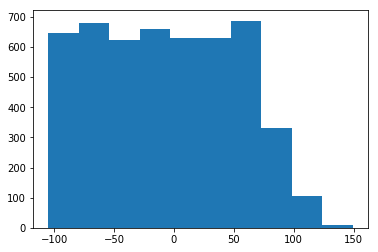

In [3]:
plt.hist(y_train)
# np.exp(10 * 0.01)

compare likelihood of test set given true mean and true variance and true variance + bias

In [4]:
tst = np.empty_like(X_train[:,0])
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  tst[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
tst

print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s)).sum())
print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s) + 100).sum())

-877440121416.7212
-31267592.02267666


Toy dataset for classification 2d

In [6]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2),0] = np.random.normal(loc=0,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=-5, 
                                                    scale=1, 
                                                    size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):,0] = np.random.normal(loc=0,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=5,
                                                    scale=1,
                                                    size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

X shape (320, 320)
------
(100,)
(100,)
(320,)
------


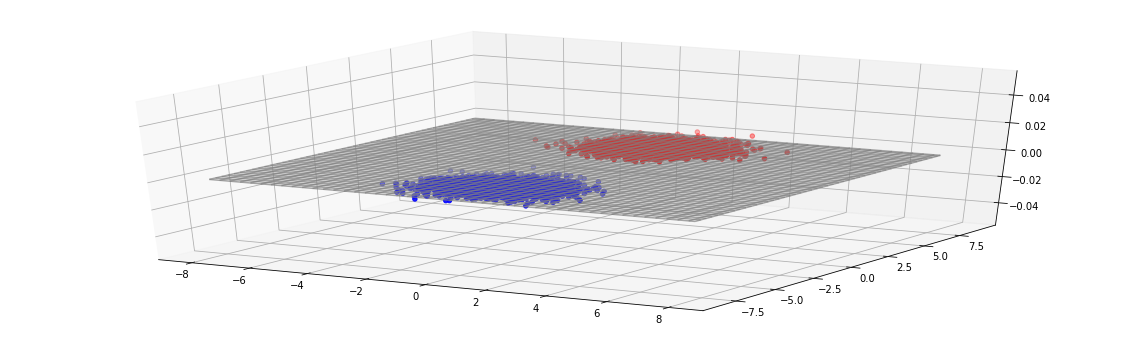

In [105]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b
    

w1 = np.array([[0,0]]).T
w2 = np.array([[0,0]]).T
W_full = np.hstack((w1, w2))
b = 0

x = y = np.arange(-8.0, 8.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = plane(X, Y, w1, b)
print("X shape", zs.shape)

# Z = zs.reshape(X.shape)

# ax.plot_surface(X, Y, Z)

# x_line = np.random.uniform(-8, 8, (100, 2))
#  = 
# print(w1.T.shape)
# y = w1.T @ x + b
# y = y.flatten()
# plt.plot(x1, x2)
# plt.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(311, projection='3d')       
ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
fig.show()
print("------")                                                        
print(x_line[:,0].shape)                                                   
print(x_line[:,1].shape)                                                   
print(y.shape)                                                        
print("------")


# ax.scatter(X1_train_grd, X2_train_grd, alpha=0.5)

# ax.plot()
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
fig.show()
# plt.show()



Toy dataset for classification 1d

In [253]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2), 0] = 0
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=4,
                                                 scale=1,
                                                 size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):, 0] = 0
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=14,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [242]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

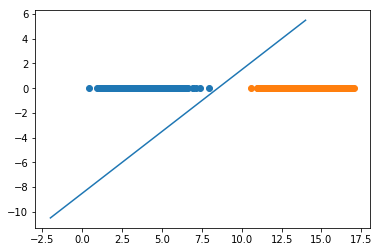

In [255]:
# a separating line!
x1 = np.linspace(-2, 14, 20)
y = x1 * 1 - 8.5

plt.scatter(X_train[y_train == 0, 1], [0]*int(X_train.shape[0]/2))
plt.scatter(X_train[y_train == 1, 1], [0]*int(X_train.shape[0]/2))
plt.plot(x1, y)

In [ ]:
# W_full
# W
# preset_preds.shape
# print('MAE of BNN with q mean == true weights: ', np.mean(np.abs(preset_preds - y_train.flatten())))
# print('acc of BNN with q mean == true weights: ', np.mean((preset_preds == y_train.flatten()).astype(int)))
# print('\n')
# print(preset_preds[1], y_train[1])
# bnn_preset.model.l1.W_log_s_DO
# bnn_preset.model.l1.b_log_s_O
# bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()

# plt.title("line with {} as slope".format(w))
# plt.plot(x1, x2)
# plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))

# ax = fig.add_subplot(311, projection='3d')                             
# print("------")                                                        
# print(x1[:,0].shape)                                                   
# print(x1[:,1].shape)                                                   
# print(y1.shape)                                                        
# print("------")                                                        
# ax.plot_surface(x1[0,1], x1[:,1], y1)                                       
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
# fig.show()
# plt.show()



## test ELBO as slope of line changes

[[0. 0.]
 [1. 0.]]
[[0.]
 [1.]]

used_b is -15.992368
used_w is  0.9352485
mean log prior  -206.307734375
mean log post est  -8.708369750976562
mean likelihood est  -5195.8565625
Accuracy with -16 as bias:  50.0 %
likelihood -5195.8565625

used_b is -15.111217
used_w is  0.9669759
mean log prior  -182.07283203125
mean log post est  -8.46707275390625
mean likelihood est  -3690.0009375
Accuracy with -15 as bias:  52.559999999999995 %
likelihood -3690.0009375

used_b is -13.949341
used_w is  0.98003715
mean log prior  -159.555859375
mean log post est  -8.479560546875
mean likelihood est  -2094.90453125
Accuracy with -14 as bias:  71.12 %
likelihood -2094.90453125

used_b is -13.001698
used_w is  1.0933197
mean log prior  -138.31279296875
mean log post est  -8.336991577148437
mean likelihood est  -1075.08171875
Accuracy with -13 as bias:  99.11999999999999 %
likelihood -1075.08171875

used_b is -11.925687
used_w is  0.87907714
mean log prior  -118.77125
mean log post est  -8.5393408203125


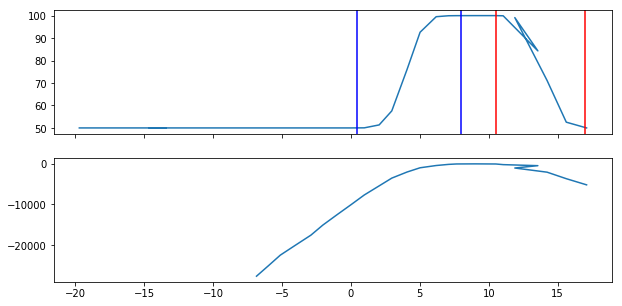

In [256]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b

# for regression toy set
# W_full = np.hstack((W, W_s))
# W_full

# b_full = np.hstack((b, b_s))
# b_full[1] = 2.0

# for 3d
# w1 = np.array([[0.0,1.0]]).T
# w2 = np.array([[0.0,0.0]]).T
# W_full = np.hstack((w1, w2))

# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)


w1 = np.array([[0.0,1.0]]).T
w2 = np.array([[0.0,0.0]]).T
W_full = np.hstack((w1, w2))

print(W_full)
print(w1)
# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)
bs = [i for i in range(-16, 20)]
used_bs = []
accuracies = []
x_int = []
likelihoods = []
for b in bs:
    b_full = np.array([b,0])
    # b_full[0], b_full[1] = 0,0
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                    prior_s=0.8, 
                                    linear_regression=True, 
                                    classification=True,
                                    preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train), predict=True).detach().numpy()
    used_b = bnn_preset.model.l1.usedBias[0].detach().numpy()
    used_w = bnn_preset.model.l1.usedWeights[:,0][1].detach().numpy()
    used_bs.append(used_b)
    
    x_intercept = -used_b / used_w
    x_int.append(x_intercept)
    print('\nused_b is', used_b)
    print('used_w is ', used_w)
    
    bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()
    acc = np.mean((preset_preds == y_train.flatten()).astype(int)) * 100
    accuracies.append(acc)
    print('Accuracy with {} as bias: '.format(b), acc, '%')
    
    likelihood = bnn_preset.mean_likelihood
    likelihoods.append(likelihood)
    print('likelihood', likelihood)
 
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax[0].plot(x_int, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')

# ax[0].scatter([np.min(X_train[y_train == 1, 1]), np.max(X_train[y_train == 1, 1])], [50,50], c='red')


ax[1].plot(x_int, likelihoods)
print('class 0 min: ', np.min(X_train[y_train == 0, 1]))
print('class 0 max: ',np.max(X_train[y_train == 0, 1]))
print('class 1 min: ', np.min(X_train[y_train == 1, 1]))
print('class 1 max: ',np.max(X_train[y_train == 1, 1]))



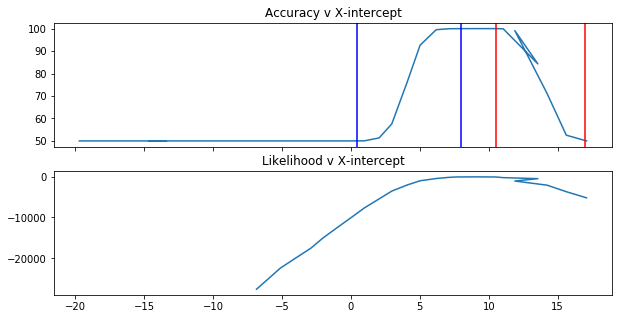

In [257]:
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax[0].set_title('Accuracy v X-intercept')
ax[0].plot(x_int, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v X-intercept')
ax[1].plot(x_int, likelihoods)

weights:  [0. 0.]
ELBO components with 0.0 as slope: 

mean log prior  -318.8373046875
mean log post est  -8.363832397460937
mean likelihood est  -24974.9625
Accuracy with 0.0 as slope:  50.0 %


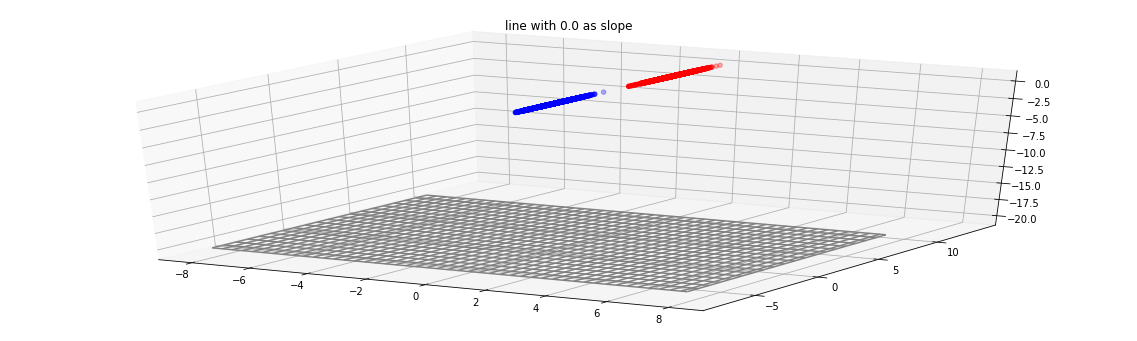

weights:  [0.1 0. ]
ELBO components with 0.1 as slope: 

mean log prior  -318.85521484375
mean log post est  -8.456224365234375
mean likelihood est  -24857.9575
Accuracy with 0.1 as slope:  50.0 %


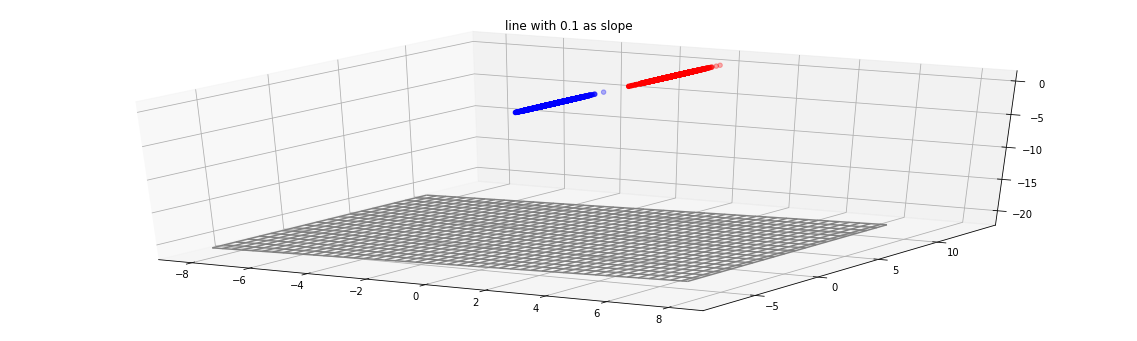

weights:  [0.5 0. ]
ELBO components with 0.5 as slope: 

mean log prior  -319.03587890625
mean log post est  -8.530648803710937
mean likelihood est  -25104.8125
Accuracy with 0.5 as slope:  50.0 %


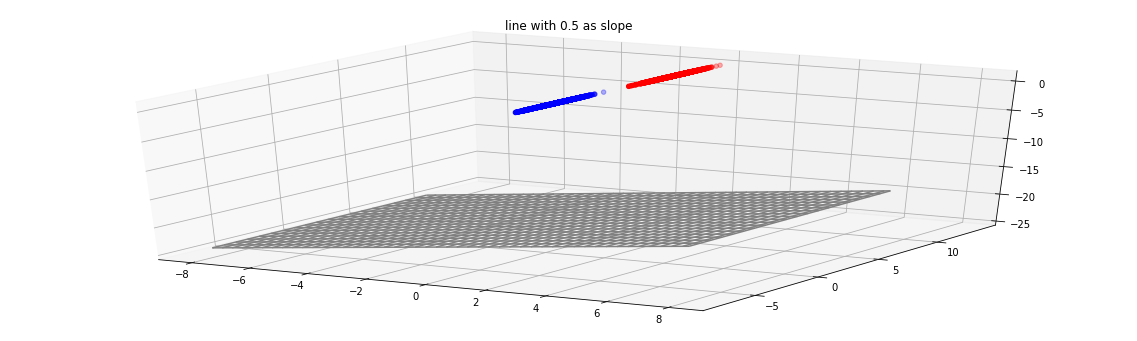

weights:  [1. 0.]
ELBO components with 1.0 as slope: 

mean log prior  -319.6490234375
mean log post est  -8.191058349609374
mean likelihood est  -25018.1175
Accuracy with 1.0 as slope:  50.0 %


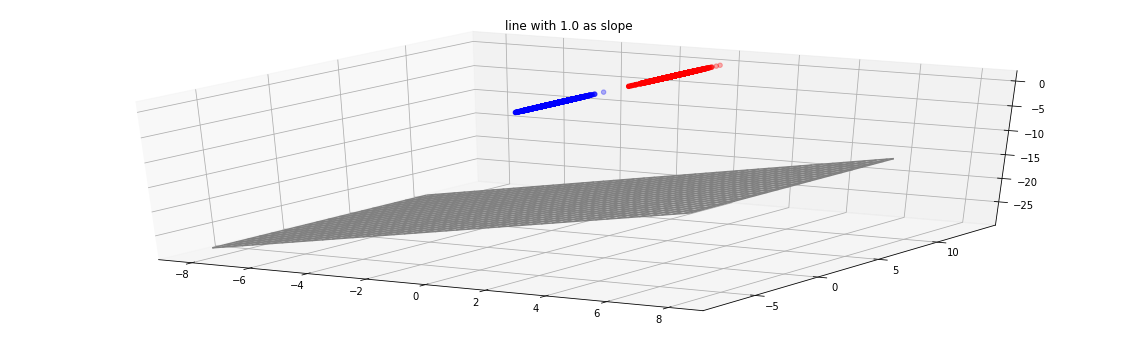

weights:  [3. 0.]
ELBO components with 3.0 as slope: 

mean log prior  -325.8983203125
mean log post est  -8.571073608398438
mean likelihood est  -25081.0975
Accuracy with 3.0 as slope:  50.0 %


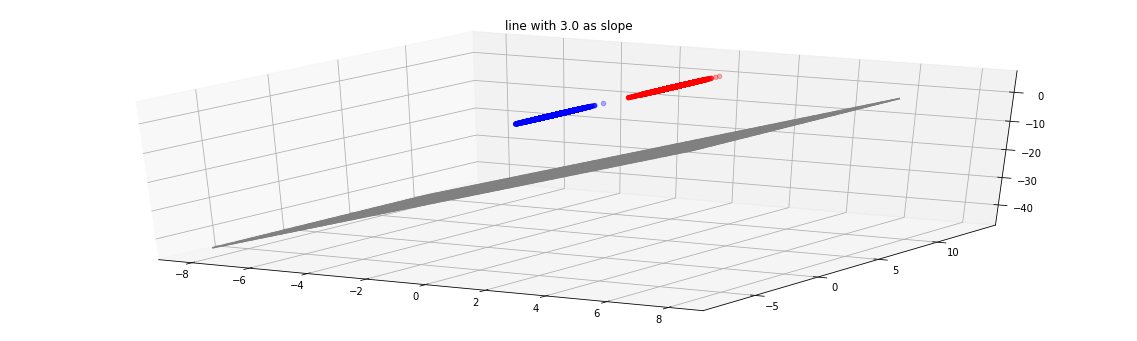

weights:  [5. 0.]
ELBO components with 5.0 as slope: 

mean log prior  -338.23
mean log post est  -8.396168212890625
mean likelihood est  -24983.42
Accuracy with 5.0 as slope:  50.0 %


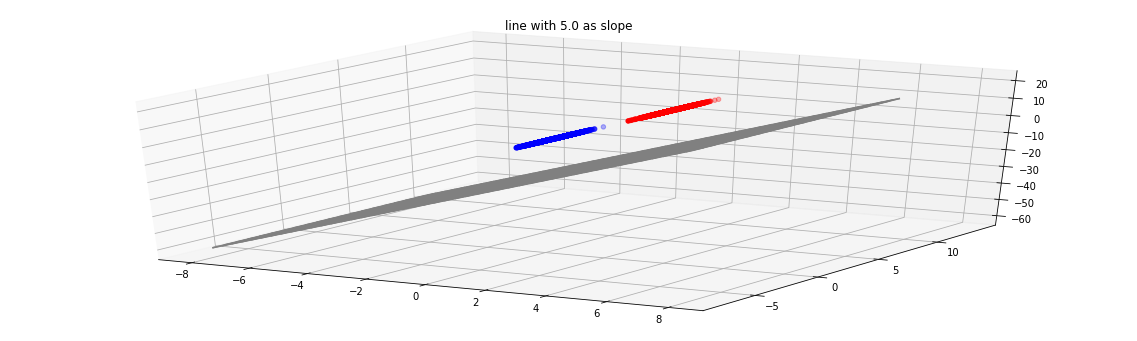

weights:  [5.5 0. ]
ELBO components with 5.5 as slope: 

mean log prior  -342.5971484375
mean log post est  -8.733505249023438
mean likelihood est  -24921.8425
Accuracy with 5.5 as slope:  50.0 %


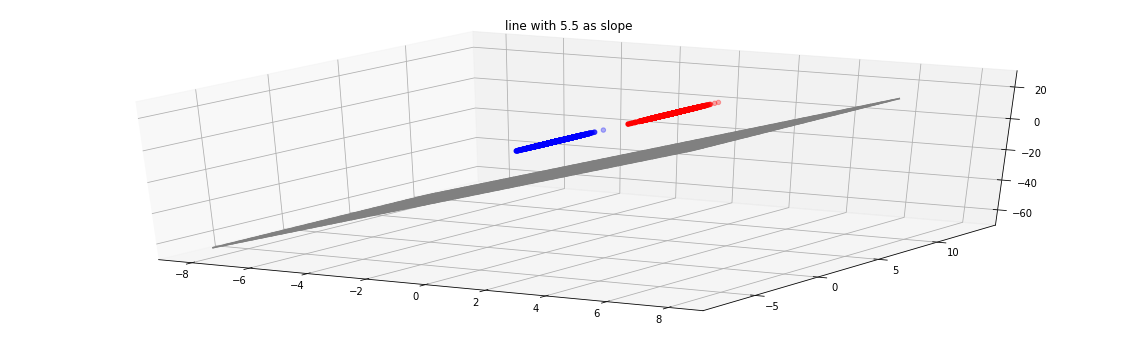

weights:  [6. 0.]
ELBO components with 6.0 as slope: 

mean log prior  -346.8836328125
mean log post est  -8.512590942382813
mean likelihood est  -24972.065
Accuracy with 6.0 as slope:  50.0 %


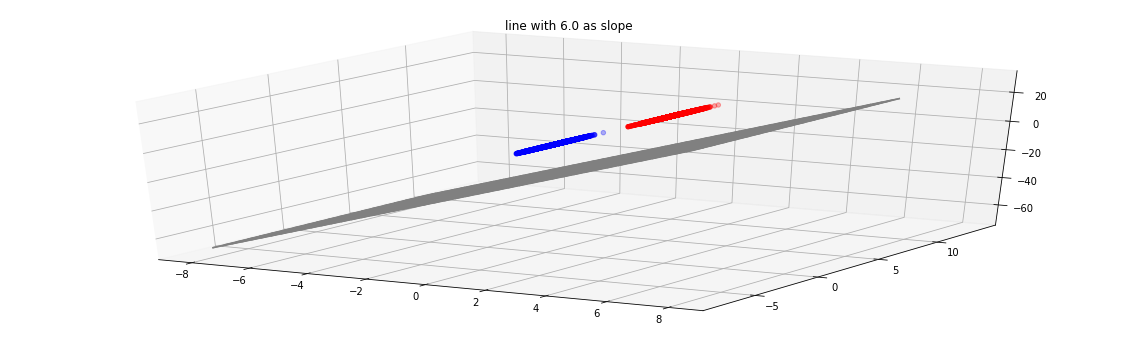

weights:  [7. 0.]
ELBO components with 7.0 as slope: 

mean log prior  -357.1958203125
mean log post est  -8.611166381835938
mean likelihood est  -25055.645
Accuracy with 7.0 as slope:  50.0 %


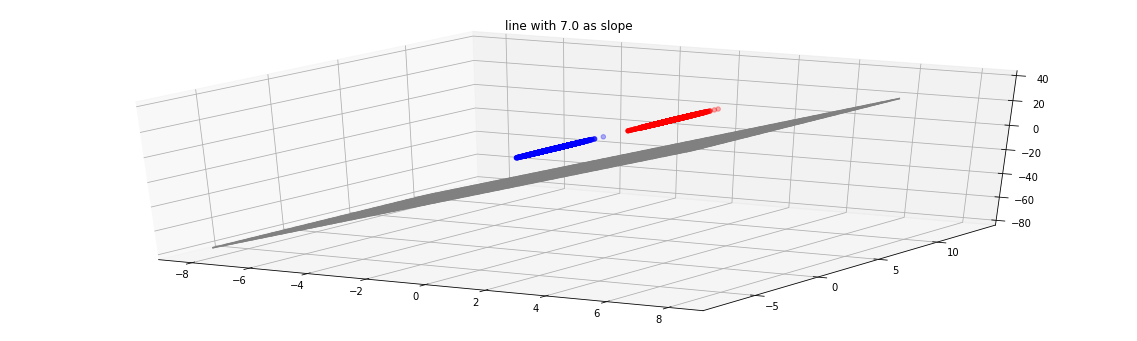

weights:  [10.  0.]
ELBO components with 10.0 as slope: 

mean log prior  -396.5961328125
mean log post est  -8.382542114257813
mean likelihood est  -24953.0875
Accuracy with 10.0 as slope:  50.0 %


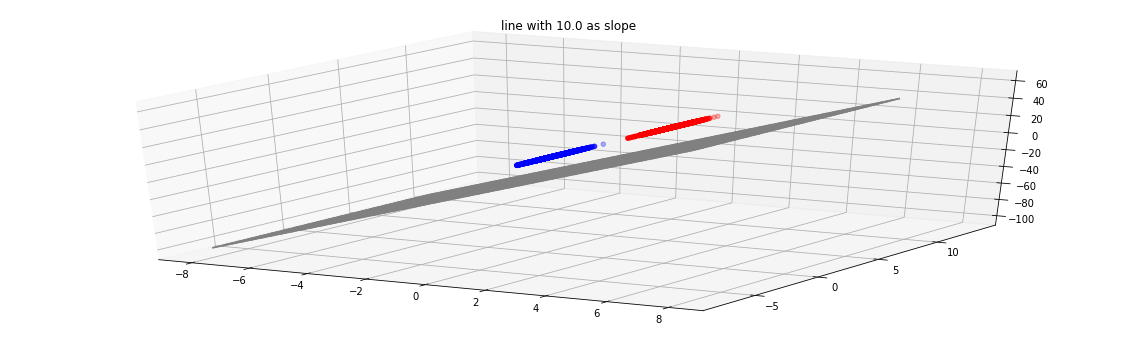

In [197]:
X_train1 = X_train
y_train1 = y_train

accuracies = []
weights = [0.0, 0.1, 0.5, 1.0, 3.0, 5.0, 5.5, 6.0, 7.0, 10.0]
for w in weights:
#     w1 = np.array([0, w])
    W_full[0][0] = w
    print('weights: ', W_full[0])
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                prior_s=0.8, 
                                linear_regression=True, 
                                classification=True,
                                preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train1), predict=True).detach().numpy()
    print('ELBO components with {} as slope: \n'.format(w))
    bnn_preset.MC_elbo(torch.Tensor(X_train1), torch.Tensor(y_train1), 9, 10, 100).detach().numpy()
    print('Accuracy with {} as slope: '.format(w), np.mean((preset_preds == y_train1.flatten()).astype(int)) * 100, '%')
    
    Z = plane(X1, X2, W_full[0], b)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(311, projection='3d') 
    ax.set_title("line with {} as slope".format(w))

    ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
    ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
    ax.plot_wireframe(X1, X2, Z, color='grey', alpha = 0.99)

#     fig.show()
    plt.show()
#     x1 = np.random.uniform(-8, 8, 100)
#     x2 = w * x1

#     plt.title("line with {} as slope".format(w))
#     plt.plot(x1, x2)
#     plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
#     plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
#     plt.ylim((-10, 10))
    

In [233]:
# bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=False)


bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=True)
bnn.fit(X_train, y_train, plot=True, n_epochs=75, learning_rate=1e-2, batch_size=100)

mean log prior  -7.596854146321615
mean log post est  -8.565336100260417
mean likelihood est  -225.59270833333332
grads  tensor([[ 0.1286,  0.0880],
        [-0.1544,  0.2463]]) 

change in w1:  [-0.00034835  0.00286394] 
cur w1:  [-0.00677582 -0.03131758] 
old w1:  [-0.00642747 -0.03418152]
change in b:  [-0.00030116  0.00049997] 
cur b:  [0.03409641 0.03590478] 
old b:  [0.03439758 0.03540481]
used weights1:  [0.3032743  0.35084468]
used bias1:  -1.330795
used weights2:  [-0.07147561 -1.0497386 ]
used bias2:  -0.78783244
differences between preds: 0.4786
standard deviation: [0.6628593  0.72246194]
bias std:           0.6833574771881104
real:  [1. 1. 1. 0. 1. 0. 0.]
Epoch:  0 	Loss:  11349.8125 	acc:  0.9994 

mean log prior  -6.765543111165365
mean log post est  -8.65885721842448
mean likelihood est  -113.87338053385416
grads  tensor([[ 0.1540, -0.0497],
        [ 0.2418,  0.0647]]) 

change in w1:  [-0.00211117 -0.00177759] 
cur w1:  [0.01032514 0.02844607] 
old w1:  [0.01243631 0.0

mean log prior  -5.628263346354166
mean log post est  -8.633963012695313
mean likelihood est  -89.5176025390625
grads  tensor([[0.0181, 0.0890],
        [0.0009, 0.1075]]) 

change in w1:  [ 0.00092686 -0.00084398] 
cur w1:  [ 0.00522022 -0.01463132] 
old w1:  [ 0.00429336 -0.01378735]
change in b:  [ 0.00115409 -0.0005813 ] 
cur b:  [ 0.00025993 -0.00204363] 
old b:  [-0.00089416 -0.00146233]
used weights1:  [-0.0856378   0.17938665]
used bias1:  0.09436177
used weights2:  [-0.34909195  0.12301912]
used bias2:  -0.20162748
differences between preds: 0.6664
standard deviation: [0.1524263  0.16867384]
bias std:           0.15985466539859772
real:  [1. 1. 1. 0. 1. 0. 0.]
Epoch:  12 	Loss:  4071.5198 	acc:  0.5334 

mean log prior  -5.618170166015625
mean log post est  -8.7301025390625
mean likelihood est  -86.4931396484375
grads  tensor([[-0.0355,  0.0618],
        [-0.0450, -0.0188]]) 

change in w1:  [0.00192618 0.00115778] 
cur w1:  [0.006973  0.0171003] 
old w1:  [0.00504682 0.015942

KeyboardInterrupt: 

In [ ]:
bnn.likelihood_est(torch.tensor(y_train), torch.tensor(y_train), 0.1)

In [25]:
np

-0.6931471805599453

In [66]:
a = torch.normal(torch.tensor([0.0]*5), torch.tensor([5.0]*5))
print(a)

sig = nn.Sigmoid()
sig(a) > 0.5

bnn.likelihood_est(torch.tensor([0.0]*5), a, 0.1)

tensor([-5.4249, -3.5355, -6.5829, -0.8022, -2.1740])


tensor(-0.5219)

mean log prior  -5.957081909179688
mean log post est  -8.4749365234375
mean likelihood est  -6174.699375
grads  tensor([[ 8.9734e+01, -5.7065e-02],
        [-1.1067e+04, -4.2979e-02]]) 

change in w1:  [-0.00271498 -0.00025465] 
cur w1:  [-0.00468861  0.0894016 ] 
old w1:  [-0.00197363  0.08965626]
change in w2:  [0.00655466 0.00397621] 
cur w2:  [ 0.00606785 -0.01825306] 
old w2:  [-0.00048681 -0.02222927]
change in b:  [0.00011519 0.00080426] 
cur b:  [ 0.43725938 -0.0231235 ] 
old b:  [ 0.4371442  -0.02392776]
full weights: 
 [[-0.00468861  0.00606785]
 [ 0.0894016  -0.01825306]]


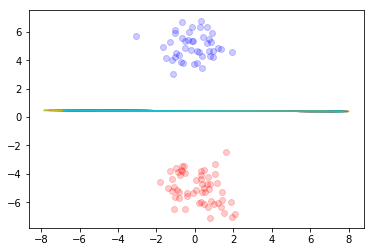

differences between samples: 0.0


TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [19]:


# Hyperparameters that work: prior_s 0.8
# Fix likelihood mean at 1?
bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, linear_regression=True, preset=True, )
bnn.fit(X_train, y_train, plot=True, n_epochs=75, learning_rate=5e-2, batch_size=100)

In [0]:
for _ in range(10):
    pred1 = X_train @ W + b 
    pred2 = X_train @ W + b + np.random.normal(loc=0, scale=np.exp(X_train @ W_s + b_s))
    mae1 = np.mean(np.abs(pred1 - y_train))
    mae2 = np.mean(np.abs(pred2 - y_train))
    print("MAE 1: ", mae1, "MAE 2:", mae2)

MAE 1:  3.0056122393554254 MAE 2: 4.229932547897288
MAE 1:  3.0056122393554254 MAE 2: 4.163598483397882
MAE 1:  3.0056122393554254 MAE 2: 4.064748158286918
MAE 1:  3.0056122393554254 MAE 2: 4.157970359536937
MAE 1:  3.0056122393554254 MAE 2: 4.18713532994711
MAE 1:  3.0056122393554254 MAE 2: 4.068806773370651
MAE 1:  3.0056122393554254 MAE 2: 4.10697160790373
MAE 1:  3.0056122393554254 MAE 2: 4.275199441081447
MAE 1:  3.0056122393554254 MAE 2: 4.105935688264671
MAE 1:  3.0056122393554254 MAE 2: 4.140327650161342


tensor([ 73.2484, -10.4592,  80.1985,  36.0612,  85.2357],
       grad_fn=<SelectBackward>)
tensor([52.9553,  7.0205, 62.6282,  ...,  5.3123,  3.1554, 38.7316],
       grad_fn=<ExpBackward>)
[[ 0.          7.83732011]
 [ 0.         -0.55350876]
 [ 0.          8.53399163]
 ...
 [ 0.         -1.71126102]
 [ 0.         -3.87444431]
 [ 0.          6.53840831]]


Text(0, 0.5, 'output[:,1] (Standard Deviation)')

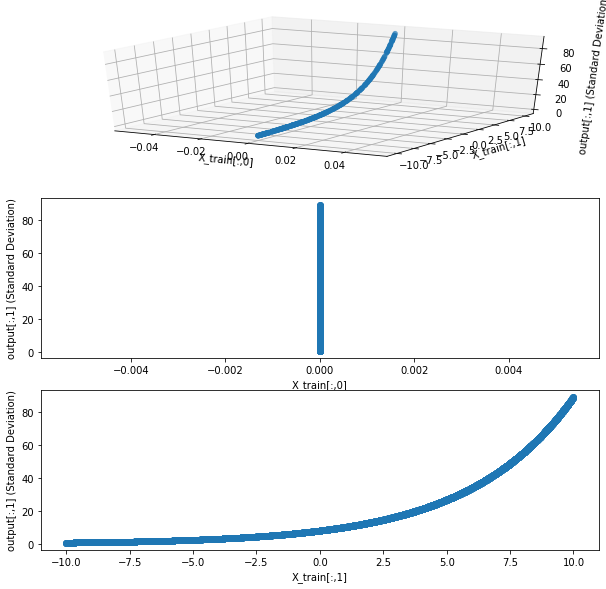

In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

final_pred = bnn.model.forward(torch.Tensor(X_train))
print(final_pred[:5,0])


pred_std = torch.exp(final_pred[:,1])

print(pred_std)
print(X_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:sparse_cap,0], X_train[:sparse_cap,1], pred_std[:sparse_cap].detach().numpy())
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')



# 2D Plot:
ax_2d_x = fig.add_subplot(312)
ax_2d_x.scatter(X_train[:,0], pred_std.detach().numpy())
ax_2d_x.set_xlabel('X_train[:,0]')
ax_2d_x.set_ylabel('output[:,1] (Standard Deviation)')


ax_2d_y = fig.add_subplot(313)
ax_2d_y.scatter(X_train[:,1], pred_std.detach().numpy())
ax_2d_y.set_xlabel('X_train[:,1]')
ax_2d_y.set_ylabel('output[:,1] (Standard Deviation)')



[ 0.7019849  0.8952522  1.1417292  1.4560653  1.8569429  2.3681886
  3.020188   3.8516934  4.9121256  6.2645106  7.9892287 10.18879
 12.993922  16.571356  21.13371   26.95215   34.372505  43.8358
 55.904476  71.295845  90.9247   ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


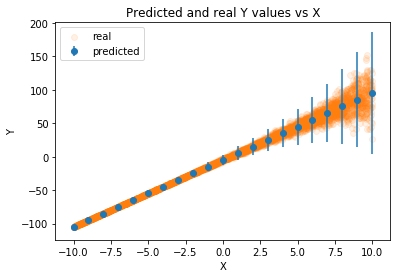

[array([0.05502322]), array([0.07427358]), array([0.10025884]), array([0.13533528]), array([0.18268352]), array([0.24659696]), array([0.33287108]), array([0.44932896]), array([0.60653066]), array([0.81873075]), array([1.10517092]), array([1.4918247]), array([2.01375271]), array([2.71828183]), array([3.66929667]), array([4.95303242]), array([6.68589444]), array([9.0250135]), array([12.18249396]), array([16.44464677]), array([22.19795128])]


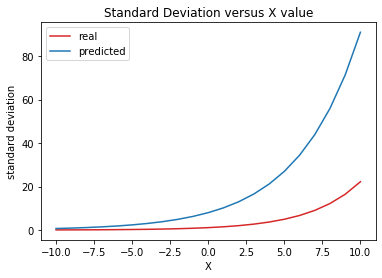

In [0]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()

print(std_pred)

# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
  std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



"""
plt.scatter(X_train[:,0], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_train[:,0], y_train, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")
"""


plt.show()

# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()

In [0]:
print(torch.exp(bnn.model.l1.W_log_s_DO))

tensor([[0.1449, 0.1307, 0.1374, 0.1398, 0.1270],
        [0.5950, 0.5896, 0.5357, 0.6016, 0.5273]], grad_fn=<ExpBackward>)


In [0]:

plt.plot([i for i in range(100)], loss_by_epoch)

NameError: ignored

In [114]:
a = torch.tensor([3,3,3])
b = torch.tensor([5,5,3])
a == b

tensor([0, 0, 1], dtype=torch.uint8)